In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features, DataParser, MovingWindow
from tabulate import tabulate
from IPython.display import clear_output
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
def smooth_bin_labels(y, dp=0.3):
    y = y.astype(np.float32)
    d = np.random.uniform(0, dp, sum(y[:, 0]==0))
    y[y[:, 0]==0, 0] = d
    y[y[:, 1]==1, 1] = 1-d
    return y

def smooth_prob_labels(y, dp=0.1):
    y = y.astype(float)
    d = np.random.uniform(-dp, dp, sum(y[:, 0]==0))
    y += dp
    return y

def stohastic_prediction(input_tensor):
    pmeans, pstds, ymeans = np.zeros((3, input_tensor.shape[0]))
    for i, x in enumerate(input_tensor):
        p = model(torch.stack([x]*7)).detach().cpu().numpy()[:, 0]
        pmeans[i] = np.median(p)
        pstds[i] = p.std()
    pmeans = pmeans*(pstds<0.1)
    return pmeans, pstds

def calc_weights(predicts, th):
    p = (predicts > th).astype(np.float32)
    return p
    #return np.clip((predicts+th)**30, 0, 1)
    
def calc_weights2(predicts, th):
    p = (predicts>th).sum(axis=0)/predicts.shape[0] >= 0.2
    #p = np.median(predicts, axis=0) > th
    return p

In [52]:
from dataloading import collect_train_data2
X1, y1 = collect_train_data2("./optimization/", 32, 5)
X2, y2 = collect_train_data2("./optimization_btc/", 32, 5)
X, y = np.vstack([X1, X2]), np.vstack([y1, y2])

65


Load pickles: 100%|██████████| 65/65 [00:00<00:00, 1476.60it/s]


(1530, 1, 6, 32) (1530, 5)
20170904 -> 20230121
74


Load pickles: 100%|██████████| 74/74 [00:00<00:00, 1699.24it/s]


(1554, 1, 6, 32) (1554, 5)
20170904 -> 20221214


test dates: 20220324:20230520: 100%|██████████| 292/292 [00:00<00:00, 109615.75it/s]


001 loss train: 62.8124 | test: 40.8906
002 loss train: 63.0673 | test: 41.2892
003 loss train: 62.5725 | test: 41.1854
004 loss train: 61.8956 | test: 41.1237
005 loss train: 62.1379 | test: 40.9608
006 loss train: 62.0685 | test: 40.9564
007 loss train: 61.9121 | test: 40.9752
008 loss train: 61.9626 | test: 40.9905
009 loss train: 61.7378 | test: 40.8033
010 loss train: 61.2935 | test: 41.1600
011 loss train: 61.5616 | test: 41.0637
012 loss train: 61.4522 | test: 41.2489
013 loss train: 60.4989 | test: 41.3901
014 loss train: 60.8690 | test: 41.0430
015 loss train: 61.4486 | test: 41.3238
016 loss train: 61.3609 | test: 40.8454
017 loss train: 61.4692 | test: 41.2900
018 loss train: 61.1020 | test: 40.9890
019 loss train: 61.7163 | test: 41.0333
020 loss train: 61.4083 | test: 41.1698
021 loss train: 61.1587 | test: 41.1736
022 loss train: 61.3065 | test: 41.1903
023 loss train: 60.6872 | test: 41.1966
024 loss train: 61.3717 | test: 40.9674
025 loss train: 61.4225 | test: 41.1796


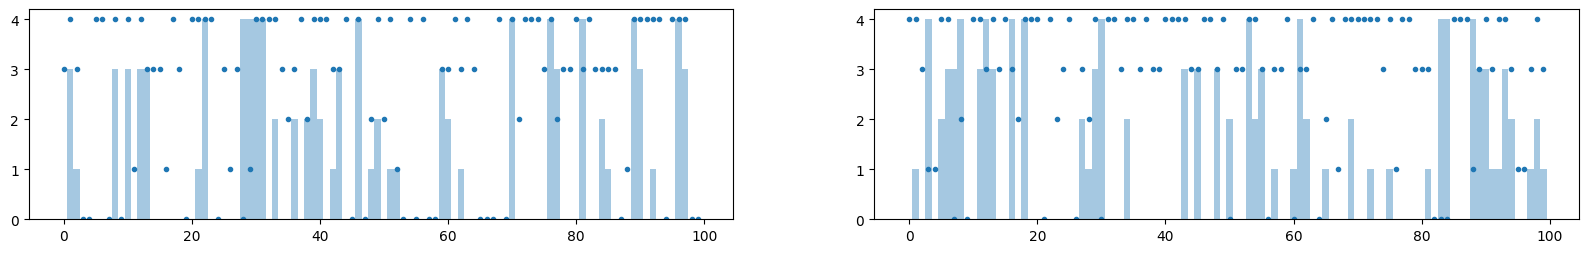

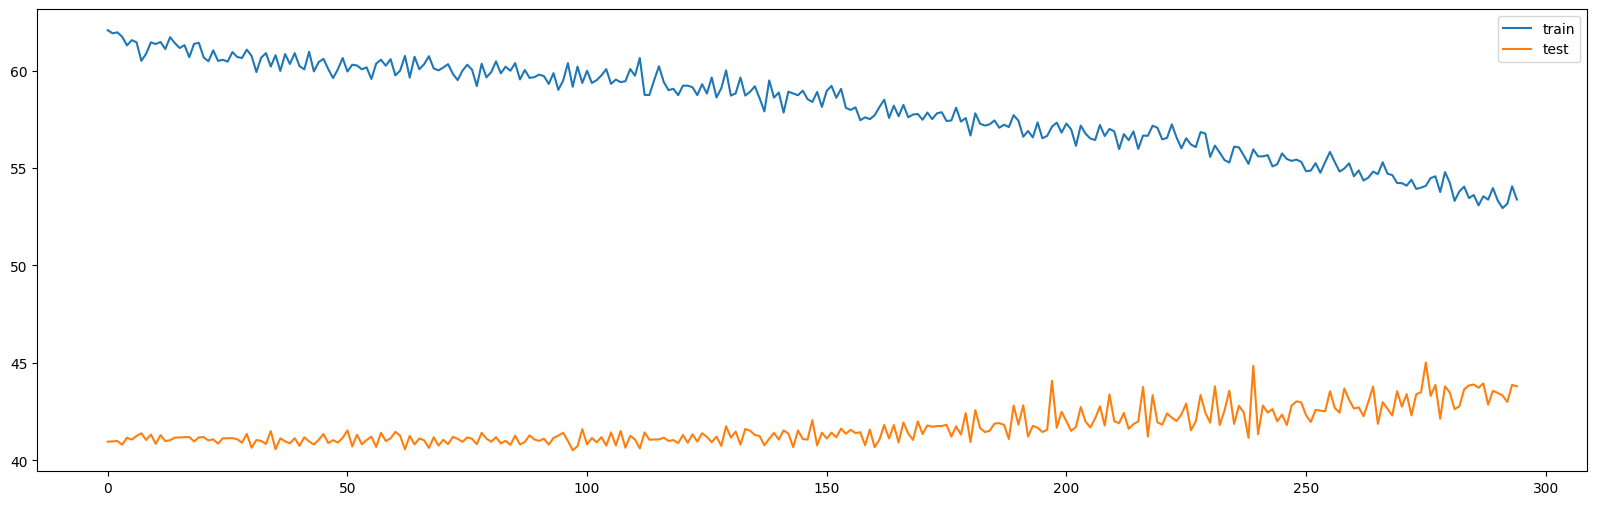

In [60]:
import torch
device = "mps"

nitrers = 10
test_split_size = 0.2
calc_test = True

pprofits, gprofits, metrics, table = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers)), []
for i in range(1):#int(1/test_split_size)):
    X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test, _ = get_data(X, y, test_split_size, 4, 5)
    X_train = torch.tensor(X_train).float().to(device)
    X_test = torch.tensor(X_test).float().to(device)
    model, loss_hist = train(X_train, y_train, X_test, y_test, batch_size=512, epochs=300, device=device, calc_test=calc_test)
    model.eval()
    p_test = model.predict(X_test)
    p_train = model.predict(X_train)
        
plt.figure(figsize=(20, 6))
plt.subplot(2, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100].argmax(1), width=[1]*100, alpha=0.4)
# plt.plot([0, 100], [threshold, threshold])
if len(p_test):
    plt.subplot(2, 2, 2)
    plt.plot(p_test[:100], ".")
    plt.bar(np.arange(100), y_test[:100].argmax(1), width=[1]*100, alpha=0.4)
plt.figure(figsize=(20, 6))
plt.plot(loss_hist[5:])
plt.legend(["train", "test"])
    
    
torch.save(model.state_dict(), "model.pth")

In [42]:
(np.eye(5)[p_train]*y_train).sum(), y_train.sum(0)

(4384.093374964315,
 array([ 904.9585, 1322.3743, 1958.1477, 3003.186 , 3536.1235],
       dtype=float32))

100%|██████████| 9888/9888 [00:00<00:00, 24178.24it/s]
2023-12-22 01:22:53.882 | INFO     | backtest:backtest:69 -                 total backtest: 0.4 sec
2023-12-22 01:22:53.882 | INFO     | backtest:backtest:70 -                 expert updates:  75 %
2023-12-22 01:22:53.882 | INFO     | backtest:backtest:71 -                 broker updates:   8 %
2023-12-22 01:22:53.882 | INFO     | backtest:backtest:72 -                  data loadings:  11 %
2023-12-22 01:22:53.883 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:22:53.883 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  88 %


87.67994209924099


100%|██████████| 10297/10297 [00:00<00:00, 24001.50it/s]
2023-12-22 01:22:56.519 | INFO     | backtest:backtest:69 -                 total backtest: 0.4 sec
2023-12-22 01:22:56.519 | INFO     | backtest:backtest:70 -                 expert updates:  76 %
2023-12-22 01:22:56.520 | INFO     | backtest:backtest:71 -                 broker updates:   7 %
2023-12-22 01:22:56.520 | INFO     | backtest:backtest:72 -                  data loadings:  11 %
2023-12-22 01:22:56.520 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:22:56.521 | INFO     | backtest:backtest:74 -                   FINAL PROFIT: 114 %


114.2121850253613


100%|██████████| 10216/10216 [00:00<00:00, 26608.04it/s]
2023-12-22 01:22:58.976 | INFO     | backtest:backtest:69 -                 total backtest: 0.4 sec
2023-12-22 01:22:58.977 | INFO     | backtest:backtest:70 -                 expert updates:  72 %
2023-12-22 01:22:58.977 | INFO     | backtest:backtest:71 -                 broker updates:   9 %
2023-12-22 01:22:58.977 | INFO     | backtest:backtest:72 -                  data loadings:  12 %
2023-12-22 01:22:58.978 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:22:58.978 | INFO     | backtest:backtest:74 -                   FINAL PROFIT: 161 %


161.40638491344544


100%|██████████| 8954/8954 [00:00<00:00, 31461.91it/s]
2023-12-22 01:23:01.372 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:01.372 | INFO     | backtest:backtest:70 -                 expert updates:  68 %
2023-12-22 01:23:01.373 | INFO     | backtest:backtest:71 -                 broker updates:  11 %
2023-12-22 01:23:01.373 | INFO     | backtest:backtest:72 -                  data loadings:  14 %
2023-12-22 01:23:01.374 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:01.374 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:   2 %


1.6188898923317505


100%|██████████| 10091/10091 [00:00<00:00, 36744.93it/s]
2023-12-22 01:23:03.837 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:03.837 | INFO     | backtest:backtest:70 -                 expert updates:  62 %
2023-12-22 01:23:03.838 | INFO     | backtest:backtest:71 -                 broker updates:  13 %
2023-12-22 01:23:03.838 | INFO     | backtest:backtest:72 -                  data loadings:  17 %
2023-12-22 01:23:03.838 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:03.839 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  63 %


63.48899784481532


100%|██████████| 9888/9888 [00:00<00:00, 24093.10it/s]
2023-12-22 01:23:06.321 | INFO     | backtest:backtest:69 -                 total backtest: 0.4 sec
2023-12-22 01:23:06.321 | INFO     | backtest:backtest:70 -                 expert updates:  75 %
2023-12-22 01:23:06.322 | INFO     | backtest:backtest:71 -                 broker updates:   8 %
2023-12-22 01:23:06.322 | INFO     | backtest:backtest:72 -                  data loadings:  11 %
2023-12-22 01:23:06.322 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:06.322 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  82 %


82.44187419237


100%|██████████| 10297/10297 [00:00<00:00, 35309.07it/s]
2023-12-22 01:23:08.669 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:08.669 | INFO     | backtest:backtest:70 -                 expert updates:  65 %
2023-12-22 01:23:08.669 | INFO     | backtest:backtest:71 -                 broker updates:  11 %
2023-12-22 01:23:08.669 | INFO     | backtest:backtest:72 -                  data loadings:  16 %
2023-12-22 01:23:08.670 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:08.670 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  75 %


75.30891781252673


100%|██████████| 10216/10216 [00:00<00:00, 29547.80it/s]
2023-12-22 01:23:11.110 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:11.111 | INFO     | backtest:backtest:70 -                 expert updates:  70 %
2023-12-22 01:23:11.111 | INFO     | backtest:backtest:71 -                 broker updates:  10 %
2023-12-22 01:23:11.112 | INFO     | backtest:backtest:72 -                  data loadings:  14 %
2023-12-22 01:23:11.112 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:11.112 | INFO     | backtest:backtest:74 -                   FINAL PROFIT: 164 %


164.23246608074794


100%|██████████| 8954/8954 [00:00<00:00, 30407.80it/s]
2023-12-22 01:23:13.461 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:13.461 | INFO     | backtest:backtest:70 -                 expert updates:  68 %
2023-12-22 01:23:13.461 | INFO     | backtest:backtest:71 -                 broker updates:  11 %
2023-12-22 01:23:13.462 | INFO     | backtest:backtest:72 -                  data loadings:  14 %
2023-12-22 01:23:13.462 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:13.462 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:   2 %


1.6188898923317505


100%|██████████| 10091/10091 [00:00<00:00, 37085.47it/s]
2023-12-22 01:23:15.875 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:15.875 | INFO     | backtest:backtest:70 -                 expert updates:  63 %
2023-12-22 01:23:15.875 | INFO     | backtest:backtest:71 -                 broker updates:  13 %
2023-12-22 01:23:15.876 | INFO     | backtest:backtest:72 -                  data loadings:  17 %
2023-12-22 01:23:15.876 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:15.876 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  63 %


63.48899784481532


100%|██████████| 9888/9888 [00:00<00:00, 28767.60it/s]
2023-12-22 01:23:18.312 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:18.312 | INFO     | backtest:backtest:70 -                 expert updates:  70 %
2023-12-22 01:23:18.313 | INFO     | backtest:backtest:71 -                 broker updates:  10 %
2023-12-22 01:23:18.313 | INFO     | backtest:backtest:72 -                  data loadings:  13 %
2023-12-22 01:23:18.313 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:18.314 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  37 %


37.432330952327256


100%|██████████| 10297/10297 [00:00<00:00, 35166.67it/s]
2023-12-22 01:23:20.696 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:20.697 | INFO     | backtest:backtest:70 -                 expert updates:  65 %
2023-12-22 01:23:20.697 | INFO     | backtest:backtest:71 -                 broker updates:  11 %
2023-12-22 01:23:20.697 | INFO     | backtest:backtest:72 -                  data loadings:  16 %
2023-12-22 01:23:20.697 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:20.698 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  74 %


73.90431494067046


100%|██████████| 10216/10216 [00:00<00:00, 25740.89it/s]
2023-12-22 01:23:23.219 | INFO     | backtest:backtest:69 -                 total backtest: 0.4 sec
2023-12-22 01:23:23.219 | INFO     | backtest:backtest:70 -                 expert updates:  73 %
2023-12-22 01:23:23.220 | INFO     | backtest:backtest:71 -                 broker updates:   9 %
2023-12-22 01:23:23.220 | INFO     | backtest:backtest:72 -                  data loadings:  12 %
2023-12-22 01:23:23.220 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:23.221 | INFO     | backtest:backtest:74 -                   FINAL PROFIT: 154 %


154.36717948407937


100%|██████████| 8954/8954 [00:00<00:00, 27501.28it/s]
2023-12-22 01:23:25.696 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:25.696 | INFO     | backtest:backtest:70 -                 expert updates:  71 %
2023-12-22 01:23:25.697 | INFO     | backtest:backtest:71 -                 broker updates:  10 %
2023-12-22 01:23:25.697 | INFO     | backtest:backtest:72 -                  data loadings:  13 %
2023-12-22 01:23:25.697 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:25.697 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:   6 %


5.596181433691159


100%|██████████| 10091/10091 [00:00<00:00, 28759.36it/s]
2023-12-22 01:23:28.126 | INFO     | backtest:backtest:69 -                 total backtest: 0.4 sec
2023-12-22 01:23:28.127 | INFO     | backtest:backtest:70 -                 expert updates:  69 %
2023-12-22 01:23:28.127 | INFO     | backtest:backtest:71 -                 broker updates:  10 %
2023-12-22 01:23:28.127 | INFO     | backtest:backtest:72 -                  data loadings:  13 %
2023-12-22 01:23:28.127 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:28.128 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  69 %


68.89038534029655


100%|██████████| 9888/9888 [00:00<00:00, 28357.97it/s]
2023-12-22 01:23:30.599 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:30.600 | INFO     | backtest:backtest:70 -                 expert updates:  70 %
2023-12-22 01:23:30.600 | INFO     | backtest:backtest:71 -                 broker updates:  10 %
2023-12-22 01:23:30.600 | INFO     | backtest:backtest:72 -                  data loadings:  13 %
2023-12-22 01:23:30.601 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:30.601 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  71 %


71.15911819182071


100%|██████████| 10297/10297 [00:00<00:00, 29956.07it/s]
2023-12-22 01:23:33.041 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:33.041 | INFO     | backtest:backtest:70 -                 expert updates:  70 %
2023-12-22 01:23:33.042 | INFO     | backtest:backtest:71 -                 broker updates:   9 %
2023-12-22 01:23:33.042 | INFO     | backtest:backtest:72 -                  data loadings:  14 %
2023-12-22 01:23:33.042 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:33.043 | INFO     | backtest:backtest:74 -                   FINAL PROFIT: 110 %


110.28463637338638


100%|██████████| 10216/10216 [00:00<00:00, 30167.29it/s]
2023-12-22 01:23:35.463 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:35.463 | INFO     | backtest:backtest:70 -                 expert updates:  69 %
2023-12-22 01:23:35.463 | INFO     | backtest:backtest:71 -                 broker updates:  10 %
2023-12-22 01:23:35.464 | INFO     | backtest:backtest:72 -                  data loadings:  14 %
2023-12-22 01:23:35.464 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:35.464 | INFO     | backtest:backtest:74 -                   FINAL PROFIT: 154 %


154.14821182797587


100%|██████████| 8954/8954 [00:00<00:00, 29521.91it/s]
2023-12-22 01:23:37.909 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:37.909 | INFO     | backtest:backtest:70 -                 expert updates:  70 %
2023-12-22 01:23:37.910 | INFO     | backtest:backtest:71 -                 broker updates:  10 %
2023-12-22 01:23:37.910 | INFO     | backtest:backtest:72 -                  data loadings:  13 %
2023-12-22 01:23:37.910 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:37.911 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:   8 %


7.560745112791549


100%|██████████| 10091/10091 [00:00<00:00, 34989.37it/s]
2023-12-22 01:23:40.297 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:40.297 | INFO     | backtest:backtest:70 -                 expert updates:  64 %
2023-12-22 01:23:40.297 | INFO     | backtest:backtest:71 -                 broker updates:  12 %
2023-12-22 01:23:40.298 | INFO     | backtest:backtest:72 -                  data loadings:  16 %
2023-12-22 01:23:40.298 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:40.298 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  75 %


75.42545674775121


100%|██████████| 9888/9888 [00:00<00:00, 22559.98it/s]
2023-12-22 01:23:42.828 | INFO     | backtest:backtest:69 -                 total backtest: 0.4 sec
2023-12-22 01:23:42.829 | INFO     | backtest:backtest:70 -                 expert updates:  59 %
2023-12-22 01:23:42.829 | INFO     | backtest:backtest:71 -                 broker updates:   8 %
2023-12-22 01:23:42.829 | INFO     | backtest:backtest:72 -                  data loadings:  28 %
2023-12-22 01:23:42.829 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:42.830 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  71 %


71.28379834844904


100%|██████████| 10297/10297 [00:00<00:00, 34924.38it/s]
2023-12-22 01:23:45.211 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:45.211 | INFO     | backtest:backtest:70 -                 expert updates:  64 %
2023-12-22 01:23:45.212 | INFO     | backtest:backtest:71 -                 broker updates:  12 %
2023-12-22 01:23:45.212 | INFO     | backtest:backtest:72 -                  data loadings:  16 %
2023-12-22 01:23:45.212 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:45.213 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  74 %


73.90431494067046


100%|██████████| 10216/10216 [00:00<00:00, 31613.53it/s]
2023-12-22 01:23:47.666 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:47.666 | INFO     | backtest:backtest:70 -                 expert updates:  66 %
2023-12-22 01:23:47.667 | INFO     | backtest:backtest:71 -                 broker updates:  11 %
2023-12-22 01:23:47.667 | INFO     | backtest:backtest:72 -                  data loadings:  15 %
2023-12-22 01:23:47.667 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:47.668 | INFO     | backtest:backtest:74 -                   FINAL PROFIT: 155 %


155.26322813697905


100%|██████████| 8954/8954 [00:00<00:00, 30595.43it/s]
2023-12-22 01:23:50.109 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:50.109 | INFO     | backtest:backtest:70 -                 expert updates:  69 %
2023-12-22 01:23:50.109 | INFO     | backtest:backtest:71 -                 broker updates:  11 %
2023-12-22 01:23:50.110 | INFO     | backtest:backtest:72 -                  data loadings:  14 %
2023-12-22 01:23:50.110 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:50.110 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  20 %


19.56998020166272


100%|██████████| 10091/10091 [00:00<00:00, 36309.57it/s]
2023-12-22 01:23:52.442 | INFO     | backtest:backtest:69 -                 total backtest: 0.3 sec
2023-12-22 01:23:52.442 | INFO     | backtest:backtest:70 -                 expert updates:  62 %
2023-12-22 01:23:52.442 | INFO     | backtest:backtest:71 -                 broker updates:  12 %
2023-12-22 01:23:52.443 | INFO     | backtest:backtest:72 -                  data loadings:  17 %
2023-12-22 01:23:52.443 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:52.443 | INFO     | backtest:backtest:74 -                   FINAL PROFIT:  63 %


63.48899784481532


100%|██████████| 55047/55047 [00:00<00:00, 61685.67it/s]
2023-12-22 01:23:53.572 | INFO     | backtest:backtest:69 -                 total backtest: 0.9 sec
2023-12-22 01:23:53.572 | INFO     | backtest:backtest:70 -                 expert updates:  34 %
2023-12-22 01:23:53.572 | INFO     | backtest:backtest:71 -                 broker updates:  20 %
2023-12-22 01:23:53.573 | INFO     | backtest:backtest:72 -                  data loadings:  33 %
2023-12-22 01:23:53.573 | INFO     | backtest:backtest:73 - ------------------------------
2023-12-22 01:23:53.574 | INFO     | backtest:backtest:74 -                   FINAL PROFIT: 430 %


429.7209291342548


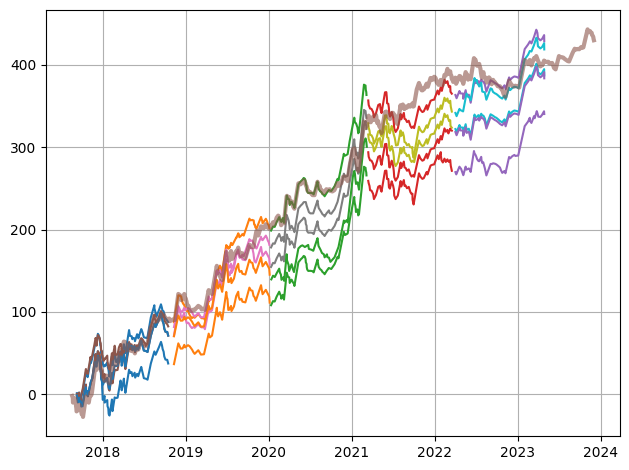

In [62]:
import sys
from experts import ExpertFormation, PyConfig
from backtest import backtest
from pathlib import Path
from dataloading import get_data, collect_train_data
import numpy as np
from loguru import logger
from tqdm import tqdm
import torch
from ml import train
import matplotlib.pyplot as plt
logger.remove()
logger.add(sys.stderr, level="INFO")



test_split_size = 0.2
device = "mps"
cfg = PyConfig().test()
cfg.run_model_device = device

for _ in range(5):
    legend, last_prof = [], 0
    for i in range(int(1/test_split_size)):
        X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test, test_dates = get_data(X, y, test_split_size, i, i+1)
        X_train = torch.tensor(X_train).float().to(device)
        model, hist = train(X_train, y_train, None, None, batch_size=512, epochs=10, device=device, calc_test=False)
        model.eval()
        # X_train = X_train.float().to(device)
        # p_train = model(X_train).detach().cpu().numpy().squeeze()[:, 0]    
        # profsum_best, threshold = -999999, np.percentile(p_train, 10)
        # for th in np.arange(0., 0.9, 0.025):
        #     profsum = f1_score(y_train[:, 0], p_train>th)
        #     if profsum > profsum_best:
        #         profsum_best = profsum
        #         threshold = th
        # model.set_threshold(threshold)
        torch.save(model.state_dict(), "model.pth")
        cfg.date_start=f"{test_dates[0][:4]}-{test_dates[0][4:6]}-{test_dates[0][6:]}"
        cfg.date_end=f"{test_dates[1][:4]}-{test_dates[1][4:6]}-{test_dates[1][6:]}"
        brok_results = backtest(cfg)
        cumsum = brok_results.profits.cumsum()
        print(brok_results.profits.sum())
        plt.plot([pos.close_date for pos in brok_results.positions], cumsum + last_prof)
        last_prof += cumsum[-1]
        plt.grid("on")
        plt.tight_layout()
        legend.append(f"{test_dates[0]}-{test_dates[1]}")

cfg.run_model_device = None
cfg.date_start="2004-01-01"
cfg.date_end="2024-01-01"
brok_results = backtest(cfg)
print(brok_results.profits.sum())
plt.plot([pos.close_date for pos in brok_results.positions], brok_results.profits.cumsum(), linewidth=3, alpha=0.6)
legend.append("baseline")
# plt.legend(legend)
plt.savefig("backtest.png")
# plt.show()



In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 64)
model.load_state_dict(torch.load("model.pth"))
model.eval()
model.to(device)

In [ ]:
p = model.forward_thresholded(X_test)[:, 0]
w_profs_test = calc_weights(p_test[0], threshold)
pprofs_test = (profs_test*w_profs_test).sum(0)
pprofs_test, profs_test.sum()

In [ ]:
pprofs_sum1 = np.nansum(pprofits, 1)
gprofs_sum1 = np.nansum(gprofits, 1)
pprofs_sum1, gprofs_sum1, (pprofs_sum1-gprofs_sum1)/abs(gprofs_sum1)

In [ ]:
plt.plot(np.array(table)[:, 3], ".-")

In [ ]:
p_train.mean(), threshold

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 32)
model.load_state_dict(torch.load("model.pth"))
model.eval()
# model.set_threshold(-6)
model.to(device)
X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split=1)
p_test = model(torch.tensor(X_test).float().to(device)).squeeze()
# profs_test.sum(), (profs_test*p_test).sum()
p_test

In [ ]:
X_train.shape

In [ ]:
list(model.named_parameters())[0]

In [ ]:
plt.plot(model(torch.tensor(X_test).float().to(device)).squeeze().detach().cpu().numpy())

In [ ]:
threshold

In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

In [ ]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [ ]:
prediction